# ct.gov Data Extractor

Pair pubmed abstracts with their `ct.gov` data

In [1]:
from cochranenlp.readers import biviewer

ct_biviewer = biviewer.ClinicalTrialsBiViewer()

### Extract Data

In [2]:
from collections import namedtuple

Targets = namedtuple('Targets', ['abstract',
                                 'pmid',
                                 'allocation',
                                 'endpoint_classification',
                                 'intervention_model',
                                 'masking',
                                 'primary_purpose',
                                 'condition',
                                 'gender',
                                 'healthy_volunteers',
                                 'maximum_age', 'minimum_age',
                                 'phase',
                                 'study_type'])

def data_generator():
    for study in ct_biviewer:
        yield Targets(study.pubmed.text_all()['abstract'], study.pubmed.text_all()['pmid'], **study.clinicaltrials.fields)
        
data = list(data_generator())
df = pd.DataFrame(data, columns=Targets._fields)
df = df[df.abstract != ''] # filter away blank abstracts

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2093 entries, 0 to 2126
Data columns (total 14 columns):
abstract                   2093 non-null object
pmid                       2093 non-null object
allocation                 1746 non-null object
endpoint_classification    1882 non-null object
intervention_model         2085 non-null object
masking                    2092 non-null object
primary_purpose            2015 non-null object
condition                  2093 non-null object
gender                     2093 non-null object
healthy_volunteers         2092 non-null object
maximum_age                2093 non-null object
minimum_age                2093 non-null object
phase                      2093 non-null object
study_type                 2093 non-null object
dtypes: object(14)
memory usage: 245.3+ KB


## Class Breakdowns

### Conditions

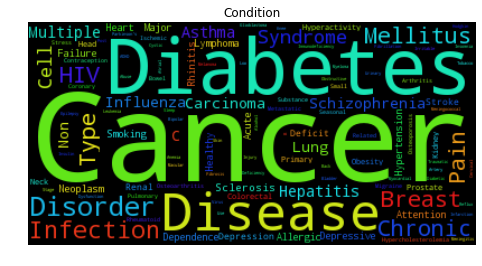

In [3]:
import wordcloud

def word_cloud(words, axes, title):
    wc = wordcloud.WordCloud().generate(words)
    axes.imshow(wc)
    axes.axis('off')
    plt.title(title)
    
fig = plt.figure(figsize=(8, 8))
axes = fig.gca()
word_cloud(' '.join(df.condition), axes, 'Condition')

### Class Balance Visualization

Minimum and maximum ages are excluded because there are so many different classes (e.g. over 17, over 18, etc.). We'd probably want to predict this value via regression instead of classification

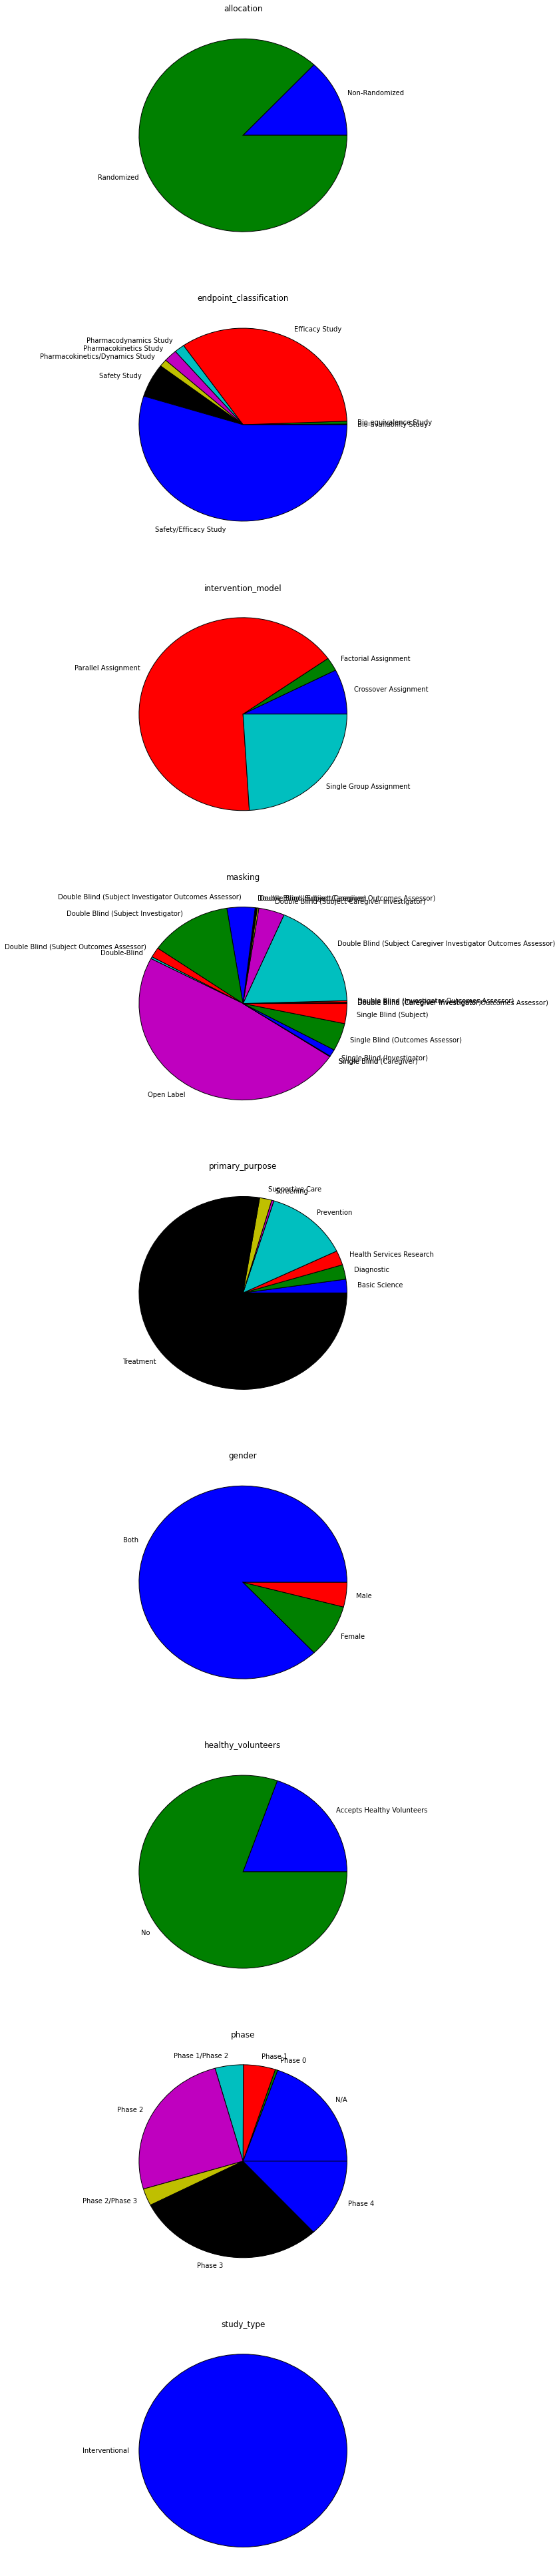

In [4]:
fig = plt.figure(figsize=(7, 100))
plt.clf()

for i, column in enumerate(df.drop(['condition', 'minimum_age', 'maximum_age'], axis=1).ix[:, 'allocation':].columns, start=1):
    axes = fig.add_subplot(13, 1, i)
    axes = df.groupby(column).size().plot(ax=axes, kind='pie', title=column)
    axes.set_ylabel('')

### Store

In [5]:
abstracts_targets = df

%store abstracts_targets

Stored 'abstracts_targets' (DataFrame)
